The `analyze_segments_time_dependent()` routine in `hormheb.analysis` is fitting a negative time constant, which doesn't make sense.

The key confusion here is that I am trying to model the temporal variation *between* the temperature difference (T_i - T_o) and the cooling rate (dT_i/dt).  The cooling rate decreases with time faster than the temperature difference: i.e. (dT_i/dt)/(T_i - T_o) decreases.

In words, this ratio (A, in units: 1/hr) can be larger when the temporal change is included (parameter b) because the initial ratio, A, is larger, but decays, 1/(1 + b*t), with time.  Thus the time-scale, 1/A ~ 18 hours.  If the ratio is not allowed to vary with time, then the ratio for all times, A, must be smaller to account for the average of the earlier (larger) and later (decayed to smaller) times.  Thus the time-independent model has a time-scale, 1/A ~ 24 hours.

In [1]:
from horemheb.config import AnalysisConfig
from horemheb.loader import load_temperature_data
from horemheb.segments import process_segments
from horemheb.analysis import analyze_segments, analyze_segments_time_dependent
from horemheb.plotting import plot_linear_fit, plot_linear_fit_comparison, plot_all_segments

import numpy as np
import pandas as pd
from dataclasses import asdict
from typing import Dict, List

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from pathlib import Path

In [2]:
# Configure analysis parameters
config = AnalysisConfig(
    delay_time=80, #300, #240, #80, #240, #180, #120,
    before_sunrise_delta_minutes=0,
    resample_minutes=5
)

In [3]:
temperature_data_file_old_door = 'temperature_logB_12.csv'
temperature_data_file = 'temperature_logC_2025-03-12.csv'

# Filter New Door data after the specified timestamp
cutoff_time = '2025-02-27 19:48:04'

---
### Old Door

In [4]:
# Old Door
dfo, dfo_r1, dfo_r2 = load_temperature_data(
    temperature_data_file,
    config,
    cutoff_time=cutoff_time,
    comparison='<='
)

In [5]:
# Find and process segments
segments = process_segments(dfo_r1, dfo_r2, config)

---
Investigate the time-dependent fit from `analysis.py:analyze_segments_time_dependent()`

In [6]:
def time_dependent_func(X, A, b):
    """
    Fitting function of form A*x/(1 + b*t)
    X should be an array of [x, t] pairs
    """
    x, t = X
    return A * x / (1 + b * t)

Sections of `analyze_segments_time_dependent()`:

In [7]:
x_all = []
y_all = []
t_all = []  # to store time differences

for segment in segments[:1]:
    temp_diff = segment['temp1'] - segment['temp2']
    
    regular_time = pd.date_range(
        start=segment['temp1'].index[0],
        end=segment['temp1'].index[-1],
        freq='1min'
    )
    
    temp_interp = pd.Series(
        index=regular_time,
        data=np.interp(mdates.date2num(regular_time),
                        mdates.date2num(segment['temp1'].index),
                        segment['temp1'].values)
    )
    
    # Calculate derivative and smooth it        
    window = 60
    dt = 1/60
    dT_dt = np.gradient(temp_interp.values) / dt
    dT_dt_smooth = pd.Series(
        index=regular_time,
        data=np.convolve(dT_dt, np.ones(window)/window, mode='same')
    )
    
    x_data = -dT_dt_smooth
    y_data = pd.Series(
        index=regular_time,
        data=np.interp(mdates.date2num(regular_time),
                        mdates.date2num(temp_diff.index),
                        temp_diff.values)
    )
    
    # Use only data between delay_time and sunrise
    mask_main = (regular_time >= segment['delay_time']) & (regular_time < segment['sunrise_time'])
    valid_data = ~np.isnan(x_data[mask_main]) & ~np.isnan(y_data[mask_main])
    
    if len(valid_data) > 0:
        x_section = x_data[mask_main][valid_data]
        y_section = y_data[mask_main][valid_data]
        
        # Calculate time since delay_time in hours
        t_section = ((regular_time[mask_main][valid_data] - segment['delay_time'])
                    .total_seconds() / 3600)  # convert to hours
        #print(t_section)
        
        x_all.extend(x_section)
        y_all.extend(y_section)
        t_all.extend(t_section)

x_all = np.array(x_all)
y_all = np.array(y_all)
t_all = np.array(t_all)

In [8]:
x_all.shape,y_all.shape,t_all.shape


((347,), (347,), (347,))

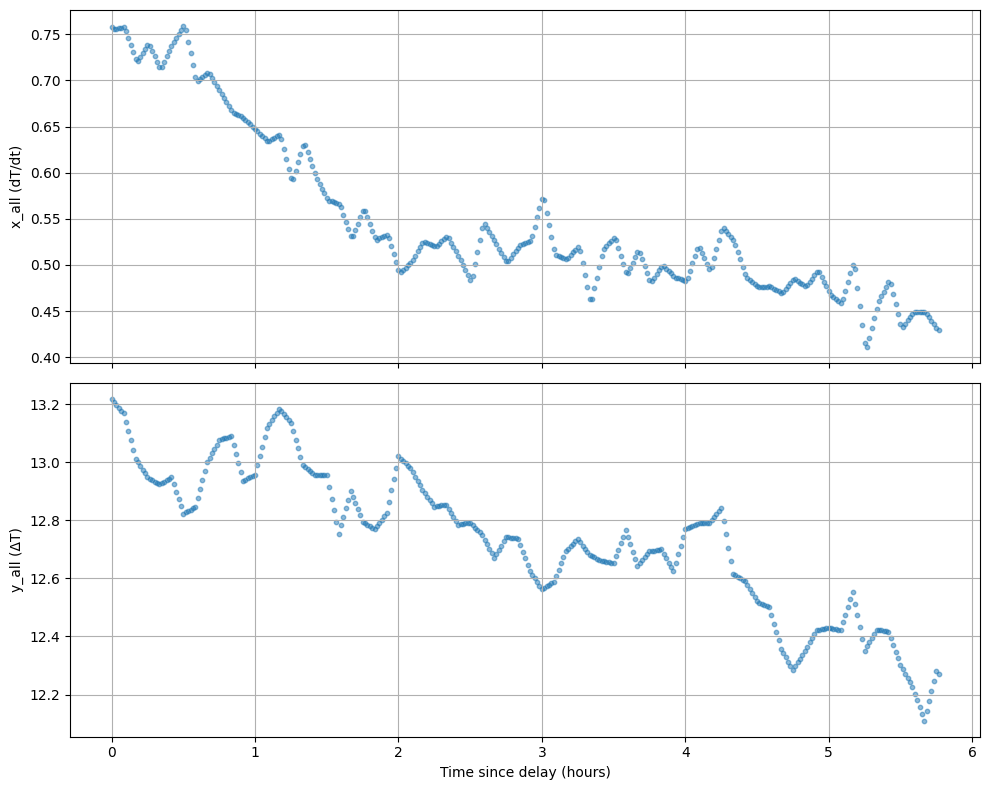

In [9]:
# Create figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot x_all vs t_all on top subplot
ax1.scatter(t_all, x_all, alpha=0.5, s=10)
ax1.set_ylabel('x_all (dT/dt)')
ax1.grid(True)

# Plot y_all vs t_all on bottom subplot 
ax2.scatter(t_all, y_all, alpha=0.5, s=10)
ax2.set_xlabel('Time since delay (hours)')
ax2.set_ylabel('y_all (ΔT)')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [10]:
from scipy.optimize import curve_fit

In [11]:
# Perform fit with time dependence
popt, pcov = curve_fit(lambda X, A, b: time_dependent_func((X[0], X[1]), A, b),
                        (y_all, t_all), x_all) #, bounds=((0, 0), (np.inf, np.inf)))
perr = np.sqrt(np.diag(pcov))
print(popt)
print(pcov)
print(perr)

[0.05497319 0.10655697]
[[1.44669598e-07 1.11671707e-06]
 [1.11671707e-06 1.16049844e-05]]
[0.00038035 0.00340661]


In [12]:
popt[0], 1./popt[0]

(np.float64(0.054973185653509164), np.float64(18.19068675231787))

In [13]:
# Perform fit with time dependence
popt_b, pcov_b = curve_fit(lambda X, A, b: time_dependent_func((X[0], X[1]), A, b),
                        (y_all, t_all), x_all, bounds=((0, 0), (np.inf, 1.e-6)))
perr_b = np.sqrt(np.diag(pcov_b))
print(popt_b, 1./popt_b[0])
print(pcov_b)
print(perr_b)

[4.30953351e-02 1.00000000e-06] 23.2043676799167
[[4.57866785e-07 2.79145826e-06]
 [2.79145826e-06 2.29251877e-05]]
[0.00067666 0.00478803]


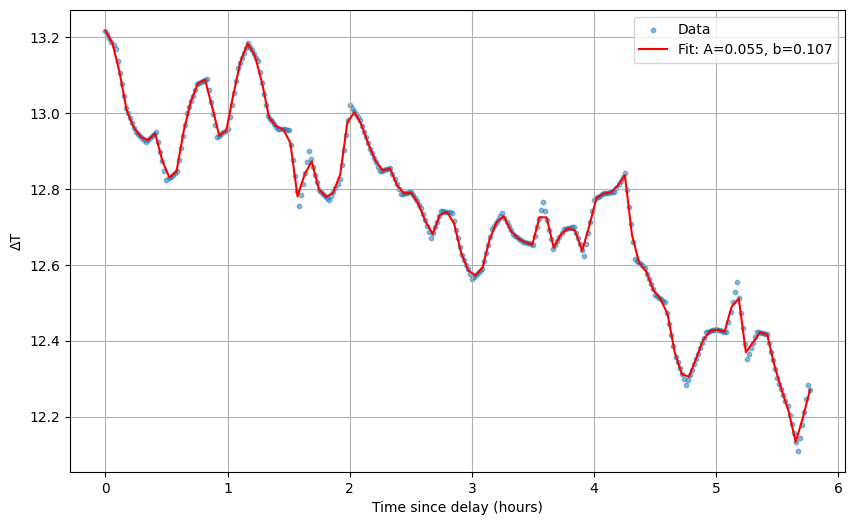

In [14]:
# Plot data and fit
plt.figure(figsize=(10,6))
plt.scatter(t_all, y_all, alpha=0.5, s=10, label='Data')

# Generate smooth curve for fit line
t_fit = np.linspace(min(t_all), max(t_all), 100)
y_fit = np.interp(t_fit, t_all, y_all)  # Interpolate x values to match t_fit
x_fit = time_dependent_func((y_fit, t_fit), *popt)
x_fit_b = time_dependent_func((y_fit, t_fit), *popt_b)

plt.plot(t_fit, y_fit, 'r-', label=f'Fit: A={popt[0]:.3f}, b={popt[1]:.3f}')
plt.xlabel('Time since delay (hours)')
plt.ylabel('ΔT')
plt.legend()
plt.grid(True)
plt.show()


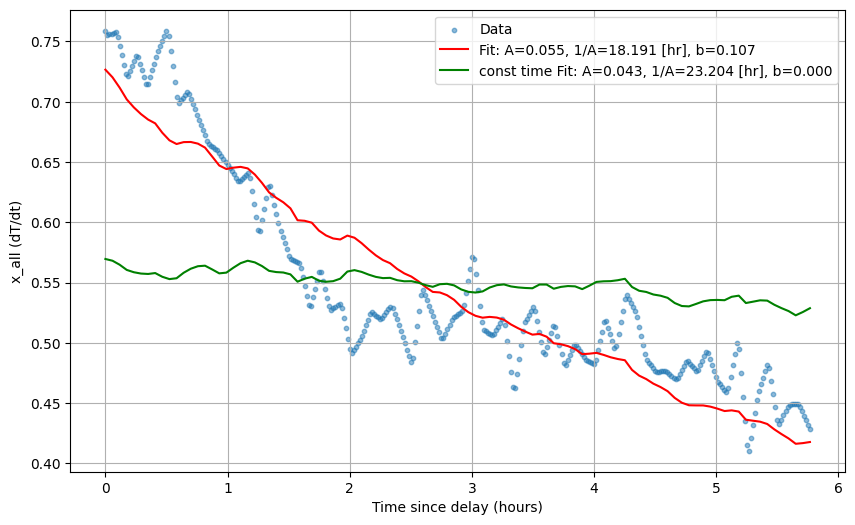

In [15]:
# Plot data and fit
plt.figure(figsize=(10,6))
plt.scatter(t_all, x_all, alpha=0.5, s=10, label='Data')

# Generate smooth curve for fit line
t_fit = np.linspace(min(t_all), max(t_all), 100)
y_fit = np.interp(t_fit, t_all, y_all)  # Interpolate x values to match t_fit
x_fit = time_dependent_func((y_fit, t_fit), *popt)

plt.plot(t_fit, x_fit, 'r-', label=f'Fit: A={popt[0]:.3f}, 1/A={1./popt[0]:.3f} [hr], b={popt[1]:.3f}')
plt.plot(t_fit, x_fit_b, 'g-', label=f'const time Fit: A={popt_b[0]:.3f}, 1/A={1./popt_b[0]:.3f} [hr], b={popt_b[1]:.3f}')
plt.xlabel('Time since delay (hours)')
plt.ylabel('x_all (dT/dt)')
plt.legend()
plt.grid(True)
plt.show()


---
Now try the fit backwards in time so that A/(1 + b*t) will mean A is fit at the end (t = 0) of the night.  Will have to un-reverse the time to get the proper curves.

In [16]:
t_all_r = t_all[-1] - t_all
# Perform fit with time dependence
popt, pcov = curve_fit(lambda X, A, b: time_dependent_func((X[0], X[1]), A, b),
                        (y_all, t_all_r), x_all) #, bounds=((0, 0), (np.inf, np.inf)))
perr = np.sqrt(np.diag(pcov))
print(popt)
print(pcov)
print(perr)

[ 0.03405011 -0.06600091]
[[5.89130734e-08 2.76125051e-07]
 [2.76125051e-07 1.70810843e-06]]
[0.00024272 0.00130695]


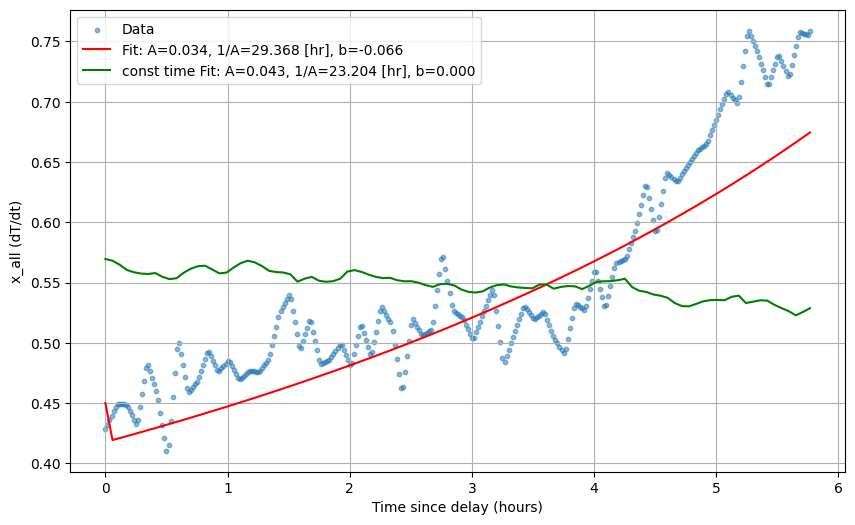

In [17]:
# Plot data and fit
plt.figure(figsize=(10,6))
plt.scatter(t_all_r, x_all, alpha=0.5, s=10, label='Data')

# Generate smooth curve for fit line
t_fit_r = np.linspace(min(t_all_r), max(t_all_r), 100)
y_fit = np.interp(t_fit_r, t_all_r, y_all)  # Interpolate x values to match t_fit
x_fit = time_dependent_func((y_fit, t_fit_r), *popt)

plt.plot(t_fit_r, x_fit, 'r-', label=f'Fit: A={popt[0]:.3f}, 1/A={1./popt[0]:.3f} [hr], b={popt[1]:.3f}')
plt.plot(t_fit_r, x_fit_b, 'g-', label=f'const time Fit: A={popt_b[0]:.3f}, 1/A={1./popt_b[0]:.3f} [hr], b={popt_b[1]:.3f}')
plt.xlabel('Time since delay (hours)')
plt.ylabel('x_all (dT/dt)')
plt.legend()
plt.grid(True)
plt.show()

So fitting the cooling rate, dT_i/dt = A/(1 + b\*t), from the beginning of the time segment gives 1/A ~ 18 hr, i.e. the cooling rate at the beginning is the quickest. forcing b = 0, so a constant decay rate across the time segment, gives 1/A ~ 23 hr, and finally, fitting from the end of the pulse, A/(1 + b\*(t_1 - t)) where t_1 is the last time, gives 1/A ~ 29 hr since this fits the A (when t = 0) at the end of the segment, when it is a minimum. 